# Processing JSON Tweets file

## Extracting tweet activity (DOW and time of day)

The script aims to process tweet data, specifically extracting the datetime, day of the week, and hour of the day when each tweet was created. It then saves this processed data into a CSV file, which is then  used for further analysis, such as creating a heatmap in Tableau to visualize tweet activity patterns based on the day of the week and time of day.

Aggregating Data: Groups the DataFrame by day_of_week and hour_of_day, counting the number of tweets for each combination using groupby and size. Resets the index of the grouped DataFrame and names the count column tweet_count

In [17]:
import json
from datetime import datetime
import pandas as pd

# Load the tweet data from the JSON file
file_path = 'duto_guerra_tweets.json'  

with open(file_path, 'r', encoding='utf-8') as file:
    tweets = json.load(file)

# Extract relevant information
data = []
for tweet in tweets:
    created_at = tweet["created_at"]
    datetime_obj = datetime.strptime(created_at, '%Y-%m-%dT%H:%M:%S.%fZ')
    day_of_week = datetime_obj.strftime('%A')
    hour_of_day = datetime_obj.hour
    data.append({"datetime": datetime_obj, "day_of_week": day_of_week, "hour_of_day": hour_of_day})

# Create a DataFrame
tweet_df = pd.DataFrame(data)

# Aggregate the data to get tweet counts by day of the week and hour of the day
tweet_counts = tweet_df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='tweet_count')

# Save detailed tweet data to CSV
#detailed_csv_file_path = 'detailed_tweets_data.csv'
#tweet_df.to_csv(detailed_csv_file_path, index=False)

# Save aggregated tweet counts to CSV
aggregated_csv_file_path = 'tweet_counts.csv'
tweet_counts.to_csv(aggregated_csv_file_path, index=False)

#print(f"Detailed tweet data saved to {detailed_csv_file_path}")
print(f"Aggregated tweet counts saved to {aggregated_csv_file_path}")


Aggregated tweet counts saved to tweet_counts.csv


## Network graph for Hashtags
The script processes tweet data to extract pairs of hashtags that appear together in tweets and saves these pairs as edges in a CSV file. This CSV file is then used to create a network graph of hashtag co-occurrences in Tableau.

This dataset can be used to analyze how different hashtags are related to each other, which can be visualized as a network graph where nodes represent hashtags and edges represent co-occurrences.

    1. parse the file and extract necessary columns
    2. further processing for Tableau bubble chart.

### 1. Parsing and extracting columns of interest

In [15]:
import json
import pandas as pd
from itertools import combinations

# Load the tweet data from the JSON file
file_path = 'duto_guerra_tweets.json'  

with open(file_path, 'r', encoding='utf-8') as file:
    tweets = json.load(file)

# Extract hashtag pairs from each tweet
hashtag_pairs = []
for tweet in tweets:
    hashtags = tweet["entities"]["hashtags"]
    hashtag_texts = [hashtag["text"] for hashtag in hashtags]
    if len(hashtag_texts) > 1:
        pairs = list(combinations(hashtag_texts, 2))
        hashtag_pairs.extend(pairs)

# Convert to a DataFrame
edges_df = pd.DataFrame(hashtag_pairs, columns=['Hashtag1', 'Hashtag2'])

# Save to CSV
csv_file_path = 'hashtag_network_edges.csv' 
edges_df.to_csv(csv_file_path, index=False)

print(f"Hashtag network edges saved to {csv_file_path}")


Hashtag network edges saved to hashtag_network_edges.csv


### 2. Further processing for tableau bubble chart
To create a bubble chart in Tableau where the size of each bubble is determined by the number of edges (connections) each hashtag has, and the color represents the cluster ID, we need to process the data further.
1. Count the Number of Edges per Hashtag: We need to count how many times each hashtag appears across all pairs in the CSV file.
2. Perform Clustering: Assign a cluster ID to each hashtag. This can be done using community detection algorithms, such as the Louvain method, which is commonly used for clustering in networks.
3. Save Processed Data: Save the hashtag counts and their respective cluster IDs to a CSV file, which can be imported into Tableau for creating the bubble chart.

In [16]:
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Load the CSV file with edges
csv_file_path = 'hashtag_network_edges.csv'
edges_df = pd.read_csv(csv_file_path)

# Create a graph from the edges
G = nx.Graph()
for _, row in edges_df.iterrows():
    G.add_edge(row['Hashtag1'], row['Hashtag2'])

# Calculate the number of edges for each hashtag (degree centrality)
degree_dict = dict(G.degree())

# Perform clustering using the Louvain method
communities = greedy_modularity_communities(G)
cluster_dict = {node: idx for idx, community in enumerate(communities) for node in community}

# Create a DataFrame with the hashtag, count of edges (degree), and cluster ID
hashtag_data = {
    'Hashtag': list(degree_dict.keys()),
    'Edge_Count': list(degree_dict.values()),
    'Cluster_ID': [cluster_dict[hashtag] for hashtag in degree_dict.keys()],
}
hashtag_df = pd.DataFrame(hashtag_data)

# Save the processed data to CSV
processed_csv_path = 'hashtag_bubble_chart_data.csv'
hashtag_df.to_csv(processed_csv_path, index=False)

print(f"Processed hashtag data saved to {processed_csv_path}")


Processed hashtag data saved to hashtag_bubble_chart_data.csv


Code Explanation:
1. The code reads the hashtag_network_edges.csv file.
2. A graph is created from the hashtag pairs using the NetworkX library.
3. It calculates the degree of each node, which represents the number of edges connected to each hashtag.
4. It uses the greedy_modularity_communities function to perform community detection (clustering) and assigns a cluster ID to each hashtag.
5. The processed data, including the hashtag, edge count, and cluster ID, is saved to a new CSV file (hashtag_bubble_chart_data.csv).

### Parsing full file
Writing a script to parse the JSON and extract specific fields. 
First identifying the key components we might want to extract from each tweet. I want to extract
Tweet ID, Creation date, Full text, Favorite count, Retweet count, User mentions, URLs, Media (if any), Hashtags, Language

    1. Loads the JSON data from the specified file.
    2. Defines a function extract_tweet_info that extracts relevant information from each tweet, joining lists into comma-separated strings for user mentions, URLs, media, and hashtags.
    3. Iterates over all tweets in the JSON file, extracting the necessary information and storing it in a list.
    4. Defines the CSV file path where the output will be saved.
    5. Writes the extracted information to the CSV file, including a header row with the field names.
Prints a success message indicating the output file path.

### Extracting hashtags, retweets, favorites to count their occurrences over time and sentiments analysis


In [1]:
import json
from datetime import datetime
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
# Load the tweet data from the JSON file
file_path = 'duto_guerra_tweets.json'  

with open(file_path, 'r', encoding='utf-8') as file:
    tweets = json.load(file)

# Extract relevant information
data = []
for tweet in tweets:
    created_at = tweet["created_at"]
    datetime_obj = datetime.strptime(created_at, '%Y-%m-%dT%H:%M:%S.%fZ')
    day_of_week = datetime_obj.strftime('%A')
    hour_of_day = datetime_obj.hour
    full_text = tweet["full_text"]
    sentiment = TextBlob(full_text).sentiment
    favorite_count = tweet["favorite_count"]
    retweet_count = tweet["retweet_count"]
    hashtags = [hashtag["text"] for hashtag in tweet["entities"]["hashtags"]]
    
    data.append({
        "datetime": datetime_obj,
        "day_of_week": day_of_week,
        "hour_of_day": hour_of_day,
        "full_text": full_text,
        "polarity": sentiment.polarity,
        "subjectivity": sentiment.subjectivity,
        "favorite_count": favorite_count,
        "retweet_count": retweet_count,
        "hashtags": ', '.join(hashtags)
    })

# Create a DataFrame
combined_df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_file_path = 'combined_tweets_data.csv' 
combined_df.to_csv(csv_file_path, index=False)
print(f"Combined tweet data saved to {csv_file_path}")


Combined tweet data saved to combined_tweets_data.csv


The script reads a JSON file containing tweet data, extracts various details (timestamp, text, sentiment, engagement metrics, hashtags), and organizes this information into a Pandas DataFrame. It then saves the DataFrame to a CSV file for further analysis.

Key Components of the Output Data:
1. Datetime - time each tweet was created.
2. Day of the Week - The day of the week each tweet was created.
3. Hour of the Day - The hour of the day each tweet was created.
4. Full Text - The complete text content of each tweet.
5. Polarity - Sentiment polarity score indicating the positivity or negativity of the tweet.
6. Subjectivity - Sentiment subjectivity score indicating how subjective or objective the tweet is.
7. Favorite Count - Number of likes for each tweet.
8. Retweet Count -  Number of retweets for each tweet.
9. Hashtags - Comma-separated list of hashtags used in each tweet.
The final output CSV file combines all these details, facilitating comprehensive analysis and visualization in tools like Tableau.

In [6]:
# Calculate tweet counts by day of week and hour of day
tweet_counts = combined_df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='tweet_count')

# Merge tweet counts back into the original DataFrame
combined_df2 = combined_df.merge(tweet_counts, on=['day_of_week', 'hour_of_day'], how='left')

# Save DataFrame to CSV
csv_file_path = 'combined_tweets_data_with_counts.csv'
combined_df2.to_csv(csv_file_path, index=False)
print(f"Combined tweet data with counts saved to {csv_file_path}")

Combined tweet data with counts saved to combined_tweets_data_with_counts.csv


The above script calculate the counts of tweets grouped by the day of the week and hour of the day and then merge this count back into the original DataFrame, and saves the file for further Tableau analysis.

### Visualizing tweet counts, favorite counts, and polarity from sentiment score

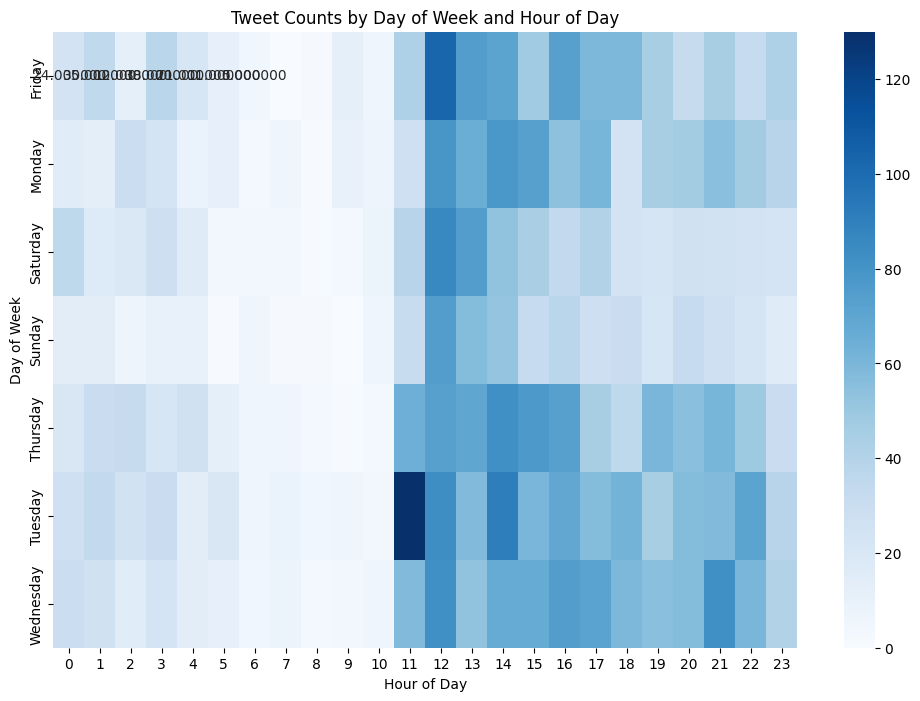

/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


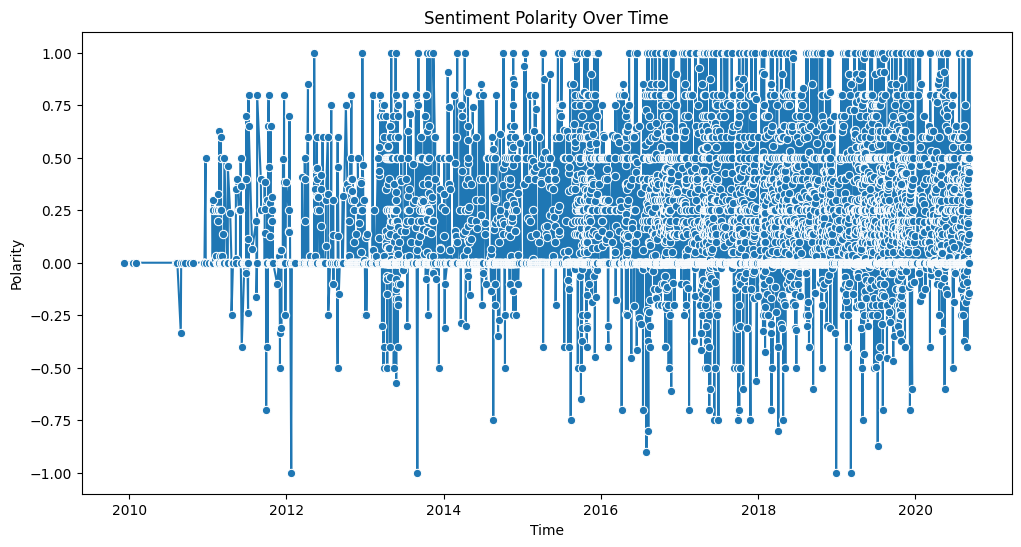

In [7]:
# Plot Tweet Counts by Day of Week and Hour of Day
tweet_counts = combined_df.groupby(['day_of_week', 'hour_of_day']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(tweet_counts, cmap="Blues", annot=True, fmt="f")
plt.title('Tweet Counts by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig('tweet_counts_heatmap.png')
plt.show()

# Plot Sentiment Analysis Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='datetime', y='polarity', marker='o')
plt.title('Sentiment Polarity Over Time')
plt.xlabel('Time')
plt.ylabel('Polarity')
#plt.savefig('sentiment_over_time.png')
plt.show()

### Engagement by day and hour

/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

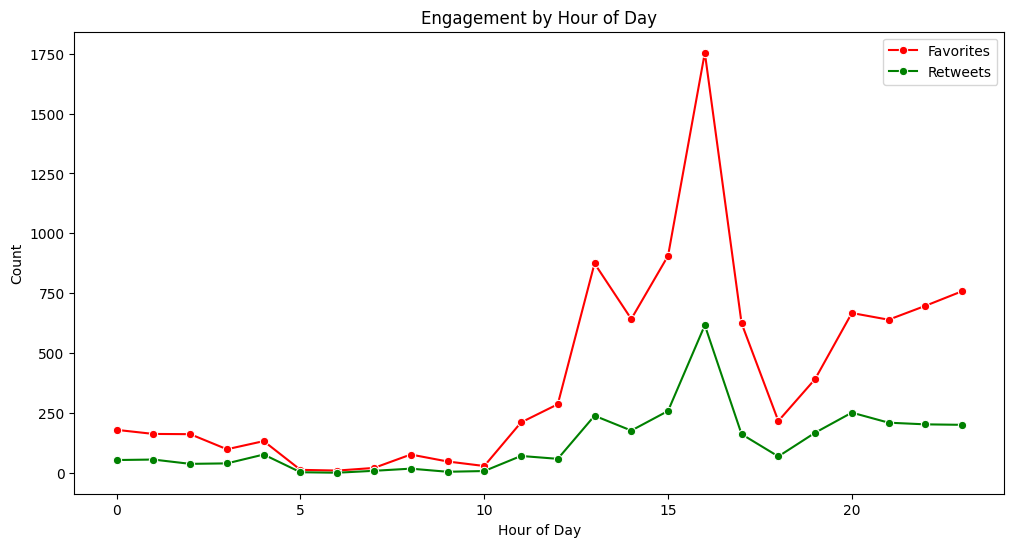

In [4]:
# Plot Engagement (Favorites and Retweets) by Hour of Day
engagement = combined_df.groupby('hour_of_day')[['favorite_count', 'retweet_count']].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=engagement, x='hour_of_day', y='favorite_count', label='Favorites', color='red', marker='o')
sns.lineplot(data=engagement, x='hour_of_day', y='retweet_count', label='Retweets', color='green', marker='o')
plt.title('Engagement by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend()
#plt.savefig('engagement_by_hour.png')
plt.show()

/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vanel/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


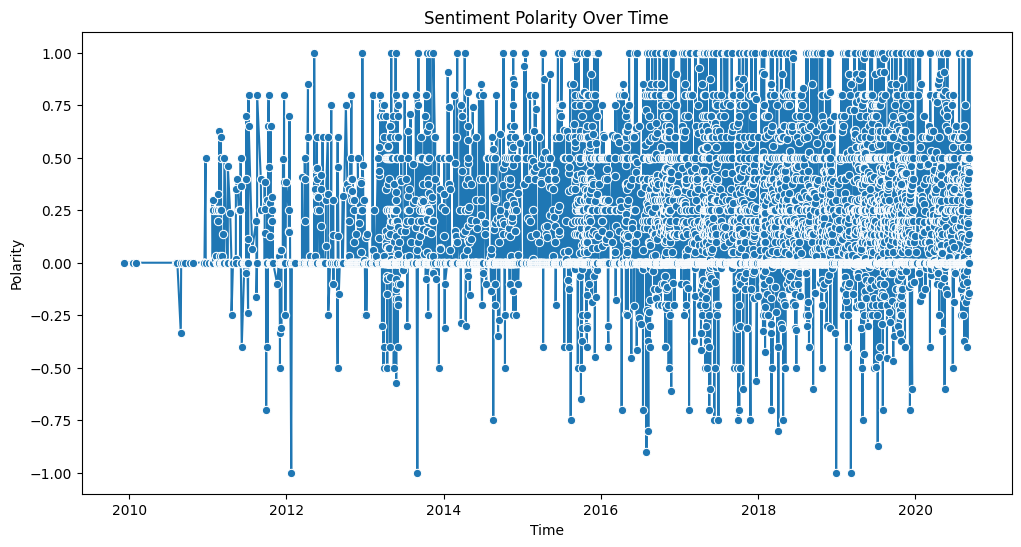

In [3]:
# Plot Sentiment Analysis Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='datetime', y='polarity', marker='o')
plt.title('Hashtag Sentiment Polarity Over Time')
plt.xlabel('Time')
plt.ylabel('Polarity')
#plt.savefig('sentiment_over_time.png')
plt.show()

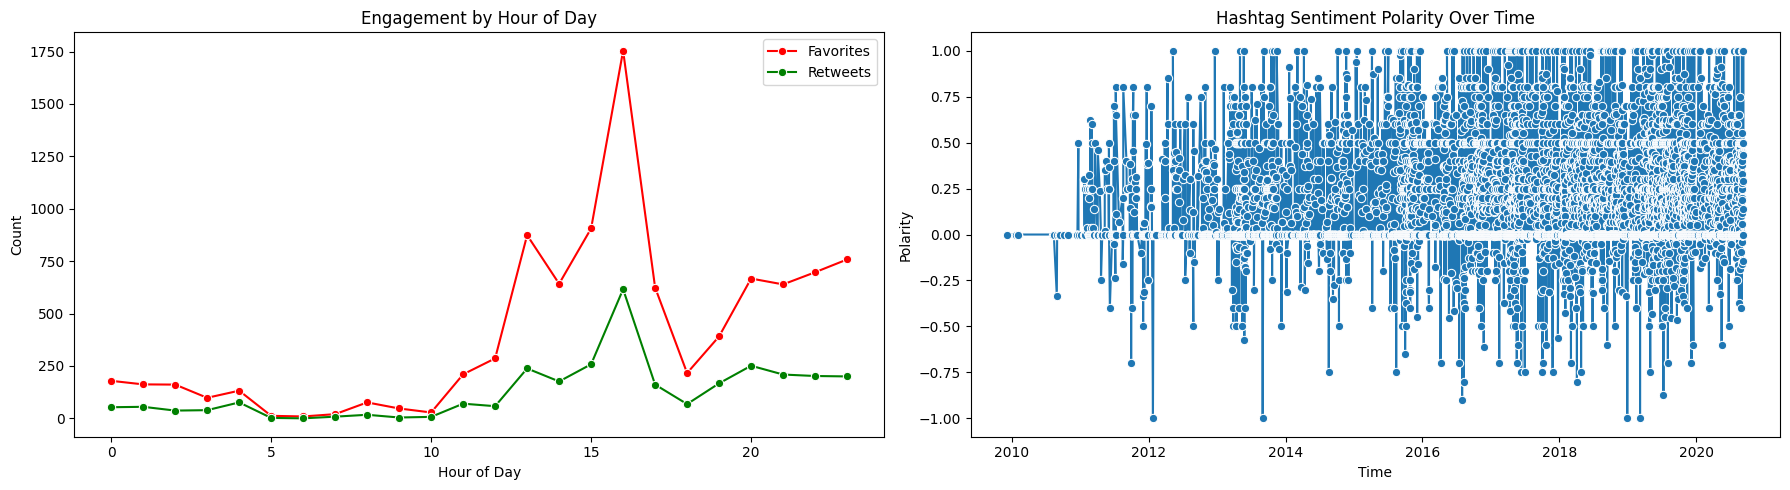

In [11]:
import warnings

# Suppress specific FutureWarnings from Pandas/Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
# Plot Engagement (Favorites and Retweets) by Hour of Day
engagement = combined_df.groupby('hour_of_day')[['favorite_count', 'retweet_count']].sum().reset_index()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot Engagement by Hour of Day
sns.lineplot(data=engagement, x='hour_of_day', y='favorite_count', label='Favorites', color='red', marker='o', ax=axs[0])
sns.lineplot(data=engagement, x='hour_of_day', y='retweet_count', label='Retweets', color='green', marker='o', ax=axs[0])
axs[0].set_title('Engagement by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Count')
axs[0].legend()

# Plot Sentiment Analysis Over Time
sns.lineplot(data=combined_df, x='datetime', y='polarity', marker='o', ax=axs[1])
axs[1].set_title('Hashtag Sentiment Polarity Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Polarity')

plt.tight_layout()
#plt.savefig('combined_plots.png')
plt.show()